In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [5]:
import os
import cv2
import time
import shutil
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
sns.set_style('darkgrid')
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization



print ('modules loaded')

modules loaded


##IMPORT LIBRARIES


##GET THE DATA






In [ ]:
BATCH_SIZE = 32
df = pd.read_csv("/content/gdrive/MyDrive/gp/Cataract/dataset/full_df.csv")
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


##CREATE DATAFRAME CONTAINS THE PATH OF IMAGE AND IT'S LABEL




In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): 
            return img 
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

In [ ]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
print(left_cataract[:15])
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:15]


['0_left.jpg' '81_left.jpg' '103_left.jpg' '119_left.jpg' '254_left.jpg'
 '294_left.jpg' '330_left.jpg' '448_left.jpg' '465_left.jpg'
 '477_left.jpg' '553_left.jpg' '560_left.jpg' '594_left.jpg'
 '611_left.jpg' '625_left.jpg']


array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg'], dtype=object)

In [ ]:
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


In [ ]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
print(right_normal[:15])
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)
print(len(cataract),len(normal))


['2964_right.jpg' '680_right.jpg' '500_right.jpg' '2368_right.jpg'
 '2820_right.jpg' '2769_right.jpg' '2696_right.jpg' '2890_right.jpg'
 '940_right.jpg' '2553_right.jpg' '3371_right.jpg' '3042_right.jpg'
 '919_right.jpg' '3427_right.jpg' '379_right.jpg']
594 500


##CREATE DATAFRAME FOR THE OTHER TYPE OF DATA

In [ ]:

dataset_dir = "/content/gdrive/MyDrive/gp/Cataract/dataset/preprocessed_images"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image= crop_image_from_gray(image)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset
        



In [ ]:
dataset = create_dataset(cataract,1)
len(dataset)


100%|██████████| 594/594 [00:12<00:00, 45.76it/s] 


588

In [ ]:
dataset = create_dataset(normal,0)
len(dataset)

100%|██████████| 500/500 [00:03<00:00, 159.45it/s]


1088

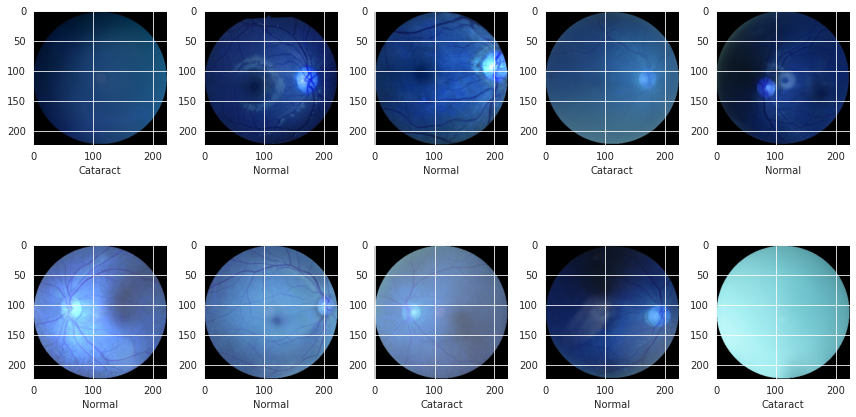

In [ ]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout() 

# Dividing dataset into x(features) & y(target)


In [ ]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])



x_train, x_valid, y_train, y_valid = train_test_split(x,y,test_size=0.1)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1)


In [ ]:

datagen = ImageDataGenerator(zoom_range=0.2, horizontal_flip=True, vertical_flip=True,
                            fill_mode='constant', cval=0.)
train_gen = datagen.flow(x_train, y_train, batch_size=32)

## Build the model <a name="build2"> </a>
We will train using a model that has been pre-trained.

In [2]:

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization
model = Sequential()

model.add(ResNet50(include_top=False, pooling='avg', weights="imagenet"))
model.add(Flatten())

model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

model.layers[0].trainable = False
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23,597,953
Trainable params: 6,145
Non-trainable params: 23,591,808
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

##Use some image data augmentation to generate randomly augmented image data from the ImageDataGenerator Object.

In [ ]:
import tensorflow as tf
from tensorflow.python.ops import histogram_ops


mc_filepath="/content/gdrive/MyDrive/gp/Cataract/callbacks/weights/weights-improvment-{epoch:02d}-{val_accuracy:.2f}.hdf5"
mc_callback = tf.keras.callbacks.ModelCheckpoint(mc_filepath,monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')

csv_callback= tf.keras.callbacks.CSVLogger('/content/gdrive/MyDrive/gp/Cataract/callbacks/my_train.csv',separator=',',append=False)
tensorboard_callback= tf.keras.callbacks.TensorBoard(log_dir='/content/gdrive/MyDrive/gp/Cataract/callbacks',histogram_freq=1,write_graph=True,write_images=True)
es_callback = tf.keras.callbacks.EarlyStopping(patience=15, verbose=1,  restore_best_weights=True,monitor="val_accuracy")
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=15, verbose=1)

##FIT THE MODEL

Epoch 1/50
28/28 [==============================] - ETA: 0s - loss: 0.2760 - accuracy: 0.8672
Epoch 1: val_accuracy improved from -inf to 0.93578, saving model to /content/gdrive/MyDrive/gp/Cataract/callbacks/weights/weights-improvment-01-0.94.hdf5
28/28 [==============================] - 26s 743ms/step - loss: 0.2760 - accuracy: 0.8672 - val_loss: 0.1986 - val_accuracy: 0.9358 - lr: 0.0010
Epoch 2/50
28/28 [==============================] - ETA: 0s - loss: 0.1690 - accuracy: 0.9387
Epoch 2: val_accuracy did not improve from 0.93578
28/28 [==============================] - 17s 630ms/step - loss: 0.1690 - accuracy: 0.9387 - val_loss: 0.1908 - val_accuracy: 0.9358 - lr: 0.0010
Epoch 3/50
28/28 [==============================] - ETA: 0s - loss: 0.1573 - accuracy: 0.9364
Epoch 3: val_accuracy did not improve from 0.93578
28/28 [==============================] - 18s 635ms/step - loss: 0.1573 - accuracy: 0.9364 - val_loss: 0.1894 - val_accuracy: 0.9358 - lr: 0.0010
Epoch 4/50
28/28 [========

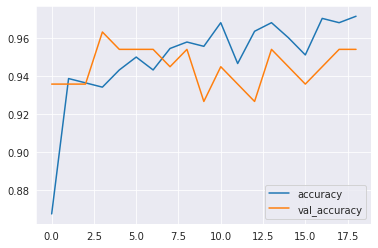

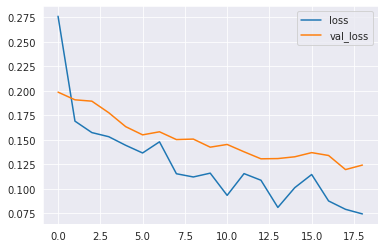

In [ ]:

history = model.fit(train_gen,
                    batch_size=32, 
                    epochs=50,
                    callbacks=[es_callback, reduce_lr,mc_callback,csv_callback,tensorboard_callback],
                    validation_data=(x_valid,y_valid),
                    verbose=1)


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

#EVALUATE THE MODEL

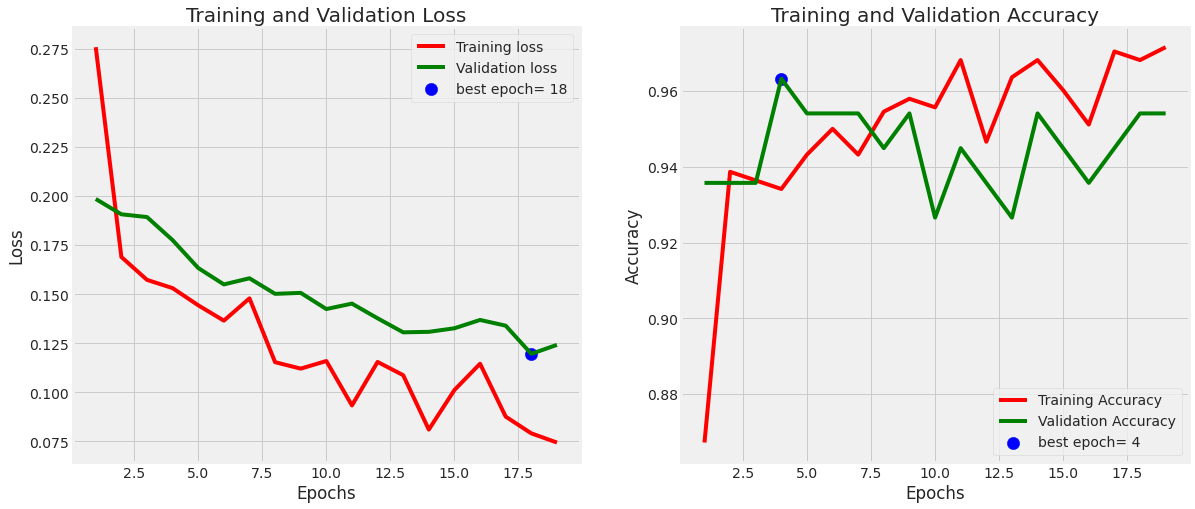

In [ ]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()

plot_training(history)

In [ ]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

4/4 [==============================] - 1s 195ms/step - loss: 0.1269 - accuracy: 0.9898
loss: 0.12692777812480927
Accuracy: 0.9897959232330322


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred = model.predict(x_test)

4/4 [==============================] - 1s 86ms/step


In [ ]:
accuracy_score(y_test,y_pred.round())

0.9897959183673469

In [ ]:
print(classification_report(y_test,y_pred.round()))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        49
           1       1.00      0.98      0.99        49

    accuracy                           0.99        98
   macro avg       0.99      0.99      0.99        98
weighted avg       0.99      0.99      0.99        98



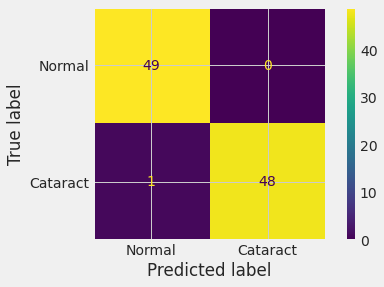

In [ ]:

import numpy
from sklearn import metrics
cm = metrics.confusion_matrix(y_test,y_pred.round())
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Normal","Cataract"])

cm_display.plot()
plt.show()


##SAVE THE MODEL


In [ ]:
#model.save("/content/gdrive/MyDrive/gp/Cataract/saved_model")

model_name = 'ResNet50'
subject = 'Cataract_classification'
acc = accuracy_score(y_test,y_pred.round()) * 100
save_path = '/content/gdrive/MyDrive/gp/Cataract/saved_model'

save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')


model was saved as /content/gdrive/MyDrive/gp/Cataract/saved_model/ResNet50-Cataract_classification-98.98.h5


#LOAD THE MODEL

In [1]:
import tensorflow as tf
Cataract_classification_model = tf.keras.models.load_model("F:/gp/Ocular_disease/cataract/saved_model/ResNet50-Cataract_classification-98.98.h5")
print(Cataract_classification_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,597,953
Trainable params: 6,145
Non-trainable params: 23,591,808
_________________________________________________________________
None


PREDICTION FUNCRION

In [20]:
import cv2
import numpy as np

image_size=224
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): 
            return img 
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img
        

def predict_class(image_path):


    image = cv2.imread(image_path)
    image= crop_image_from_gray(image)
    image = cv2.resize(image,(image_size,image_size))
    
    image=np.array(image)
    image=image.reshape(-1,image_size,image_size,3)

    y = Cataract_classification_model.predict([image])
    return y
prediction =predict_class("F:/gp/Ocular_disease/cataract/old_cataract/cataract_dataset/1_Normal/NL_012.png")  
print(prediction[0][0])
if prediction[0][0] >0.45:
  print("Cataract")
else:
  print("Normal")

1/1 [==============================] - 0s 185ms/step
0.054521147
Normal
